In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import torch
import tqdm
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from torch.utils.data import DataLoader

from estuary.low_quality.data import LowQualityDataModule
from estuary.low_quality.module import LowQualityModule
from estuary.model.data import EstuaryDataset, _load_labels
from estuary.util.img import broad_band, false_color

In [12]:
import json

all_datas = []
regions_root = Path("/Volumes/x10pro/estuary/ca_grids")
years = range(2017, 2026)
months = range(1, 13)
doves = ("superdove", "dove")

for region_p in regions_root.iterdir():
    region = region_p.stem
    for year in years:
        for month in months:
            for dove in doves:
                search_json_path = (
                    Path(f"/Volumes/x10pro/estuary/ca_all/{dove}/results")
                    / str(year)
                    / str(month)
                    / str(region)
                    / "filtered_search_results.json"
                )
                if not search_json_path.exists():
                    continue

                with open(search_json_path) as f:
                    asset_data = json.load(f)

                prop_data = []
                for p in asset_data:
                    pp = p["properties"]
                    pp["asset_id"] = p["id"]
                    prop_data.append(pp)
                all_datas.append(pd.DataFrame(prop_data))

In [15]:
all_df = pd.concat(all_datas)
all_df["asset_id_short"] = all_df.asset_id.apply(lambda a: "_".join(a.split("_")[:2]))
all_df.head()

,acquired,anomalous_pixels,clear_confidence_percent,clear_percent,cloud_cover,cloud_percent,ground_control,gsd,heavy_haze_percent,instrument,...,snow_ice_percent,strip_id,sun_azimuth,sun_elevation,updated,view_angle,visible_confidence_percent,visible_percent,asset_id,asset_id_short
0,2017-05-28T17:43:42.631067Z,0.01,86,100,0.00,0,True,4.0,0,PS2,...,0,522377,105.3,60.5,2024-04-17T02:37:49Z,0.0,58,100,20170528_174342_1009,20170528_174342
1,2017-05-27T17:44:13.202718Z,0.05,64,33,0.56,56,True,4.0,0,PS2,...,0,520760,105.8,60.4,2024-10-22T17:52:51Z,0.9,57,44,20170527_174413_0f34,20170527_174413
2,2017-05-21T17:44:14.290877Z,0.01,86,21,0.77,77,True,4.0,0,PS2,...,0,515409,107.7,59.9,2024-10-22T17:52:42Z,0.8,62,23,20170521_174414_1039,20170521_174414
3,2017-05-21T17:44:13.227524Z,0.01,85,58,0.40,40,True,4.0,0,PS2,...,0,515409,107.8,59.9,2024-10-22T17:52:46Z,0.8,65,60,20170521_174413_1039,20170521_174413
4,2017-05-14T17:43:40.795873Z,0.06,62,10,0.26,26,True,4.0,0,PS2,...,0,513434,110.2,59.0,2024-10-22T17:52:51Z,0.7,54,74,20170514_174340_1023,20170514_174340


In [16]:
df = pd.read_parquet("/Volumes/x10pro/estuary/ca_all/data_stats.parquet")
df.head()

,acquired,anomalous_pixels,clear_confidence_percent,clear_percent,cloud_cover,cloud_percent,ground_control,gsd,heavy_haze_percent,instrument,...,tif_std_4,p90_vis,p95_vis,bright_frac,low_tex_frac,nir_ratio,mean_brightness,std_texture,lap_var,spec_consistency
0,2017-05-28T17:43:42.631067Z,0.01,86,100,0.00,0,True,4.0,0,PS2,...,870.924683,1640.666626,1883.666626,0.173438,0.036776,2.170949,801.128296,462.565430,4386.635254,0.992294
1,2017-05-27T17:44:13.202718Z,0.05,64,33,0.56,56,True,4.0,0,PS2,...,909.661804,1996.333374,2218.000000,0.180670,0.026813,1.865665,1090.065796,527.910950,7195.332031,0.988543
2,2017-05-13T17:49:24.2877Z,0.02,83,87,0.07,7,True,3.9,0,PS2,...,902.330200,1808.000000,2069.750061,0.180271,0.244672,1.859764,838.523499,550.480164,5128.672852,0.990755
3,2017-06-29T17:45:31.682234Z,0.01,97,100,0.00,0,True,3.9,0,PS2,...,814.969421,1888.000000,2260.000000,0.167017,0.186291,1.541564,1033.346313,524.623718,8285.262695,0.987714
4,2017-06-28T17:45:41.323644Z,0.01,94,100,0.00,0,True,3.9,0,PS2,...,766.441589,1710.333374,2022.000000,0.164540,0.177220,1.694341,857.642639,521.602844,7629.768066,0.989797


In [20]:
available = all_df[~all_df.asset_id.isin(df.asset_id)]
available.head()

,acquired,anomalous_pixels,clear_confidence_percent,clear_percent,cloud_cover,cloud_percent,ground_control,gsd,heavy_haze_percent,instrument,...,snow_ice_percent,strip_id,sun_azimuth,sun_elevation,updated,view_angle,visible_confidence_percent,visible_percent,asset_id,asset_id_short
2,2017-05-21T17:44:14.290877Z,0.01,86,21,0.77,77,True,4.0,0,PS2,...,0,515409,107.7,59.9,2024-10-22T17:52:42Z,0.8,62,23,20170521_174414_1039,20170521_174414
3,2017-05-21T17:44:13.227524Z,0.01,85,58,0.40,40,True,4.0,0,PS2,...,0,515409,107.8,59.9,2024-10-22T17:52:46Z,0.8,65,60,20170521_174413_1039,20170521_174413
4,2017-05-14T17:43:40.795873Z,0.06,62,10,0.26,26,True,4.0,0,PS2,...,0,513434,110.2,59.0,2024-10-22T17:52:51Z,0.7,54,74,20170514_174340_1023,20170514_174340
5,2017-05-13T17:44:09.054062Z,0.01,74,100,0.00,0,True,4.0,0,PS2,...,0,501475,110.7,59.0,2024-04-17T00:13:56Z,0.9,74,100,20170513_174409_0f34,20170513_174409
0,2017-06-29T17:45:31.744888Z,0.01,98,100,0.00,0,True,3.9,0,PS2,...,0,587798,101.5,60.3,2024-12-20T19:15:11Z,0.1,77,100,20170629_174531_0f28,20170629_174531


In [23]:
clear_av = available[(available.clear_percent > 10) & (available.anomalous_pixels < 0.05)]
len(available), len(clear_av)

(80864, 63466)

In [5]:
module = LowQualityModule.load_from_checkpoint(
    run_path,
    accelerator="cpu",
    workers=0,
    persistent_workers=False,
    batch_size=1,
    prefetch_factor=0,
    strict=False,
)
module = module.eval()

In [6]:
dm = LowQualityDataModule(module.conf)
dm.prepare_data()
dm.setup()

In [8]:
dl = dm.test_dataloader()

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = dm.val_aug(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

thresholds = np.linspace(0, 1, 101)  # e.g., 0.00, 0.01, ..., 1.00
scores = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0.0)
    rec = recall_score(y_true, y_pred)
    scores.append((t, f1, acc, prec, rec))

# put into DataFrame for analysis
df_scores = pd.DataFrame(scores, columns=["threshold", "f1", "accuracy", "precision", "recall"])

# best threshold by F1
best_f1_row = df_scores.loc[df_scores["f1"].idxmax()]
print(best_f1_row)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8654/8654 [03:34<00:00, 40.30it/s]


threshold    0.680000
f1           0.640562
accuracy     0.958632
precision    0.664583
recall       0.618217
Name: 68, dtype: float64


(array([5984.,  996.,  455.,  298.,  209.,  130.,  123.,   98.,  121.,
         240.]),
 array([0.00271931, 0.10216628, 0.20161325, 0.3010602 , 0.40050718,
        0.49995413, 0.59940112, 0.69884807, 0.79829502, 0.89774203,
        0.99718899]),
 <BarContainer object of 10 artists>)

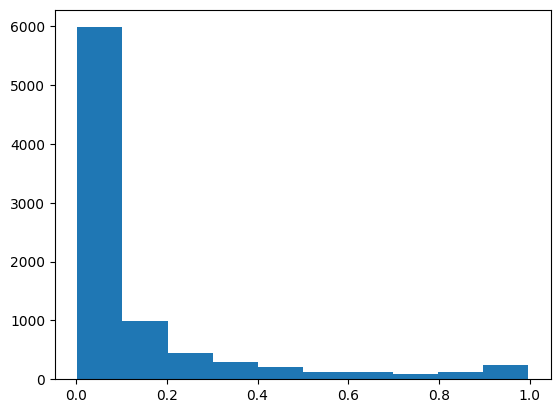

In [9]:
plt.hist(y_prob)

<Axes: xlabel='threshold', ylabel='f1'>

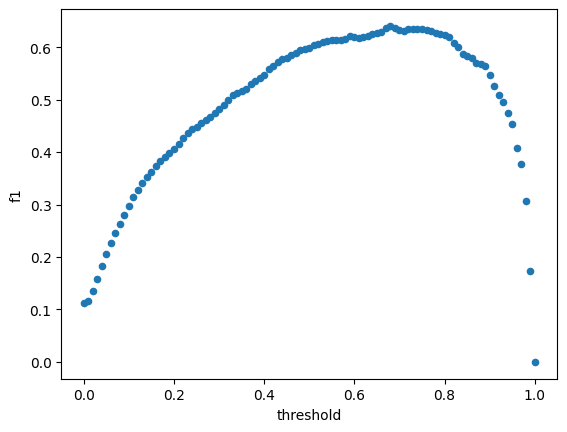

In [10]:
df_scores.plot.scatter(x="threshold", y="f1")

In [13]:
df_scores[df_scores.threshold == 0.68]

,threshold,f1,accuracy,precision,recall
68,0.68,0.640562,0.958632,0.664583,0.618217


In [14]:
results_df = []
threshold = 0.68

In [16]:
dl = dm.val_dataloader()

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = dm.val_aug(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

    for i in range(len(probs_pos)):
        results_df.append(
            {
                "source_tif": batch["source_tif"][i],
                "y_true": batch["label"][i].detach().cpu().numpy(),
                "y_prob": probs_pos[i].detach().cpu().numpy()[0],
                "y_pred": (probs_pos[i] > threshold).to(torch.int32).detach().cpu().numpy()[0],
                "region": int(Path(batch["source_tif"][i]).parents[2].name),
                "dataset": "val",
            }
        )

accuracy_score(y_true, np.int32(np.array(y_prob) > threshold))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8455/8455 [03:41<00:00, 38.21it/s]


0.9332939089296275

In [17]:
dl = dm.test_dataloader()

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = dm.val_aug(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

    for i in range(len(probs_pos)):
        results_df.append(
            {
                "source_tif": batch["source_tif"][i],
                "y_true": batch["label"][i].detach().cpu().numpy(),
                "y_prob": probs_pos[i].detach().cpu().numpy()[0],
                "y_pred": (probs_pos[i] > threshold).to(torch.int32).detach().cpu().numpy()[0],
                "region": int(Path(batch["source_tif"][i]).parents[2].name),
                "dataset": "test",
            }
        )

accuracy_score(y_true, np.int32(np.array(y_prob) > threshold))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8654/8654 [03:47<00:00, 38.04it/s]


0.9586318465449503

In [18]:
dl = dm.train_dataloader()

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = dm.val_aug(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

    for i in range(len(probs_pos)):
        results_df.append(
            {
                "source_tif": batch["source_tif"][i],
                "y_true": batch["label"][i].detach().cpu().numpy(),
                "y_prob": probs_pos[i].detach().cpu().numpy()[0],
                "y_pred": (probs_pos[i] > threshold).to(torch.int32).detach().cpu().numpy()[0],
                "region": int(Path(batch["source_tif"][i]).parents[2].name),
                "dataset": "train",
            }
        )

accuracy_score(y_true, np.int32(np.array(y_prob) > threshold))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51542/51542 [24:01<00:00, 35.76it/s]


0.8768383066237243

In [30]:
results_df = pd.DataFrame(results_df)
results_df["correct"] = results_df.y_true == results_df.y_pred
results_df["region"] = results_df.source_tif.apply(lambda a: Path(a).parents[1].name)

results_df.head(5)

,source_tif,y_true,y_prob,y_pred,region,dataset,correct
0,/Users/kyledorman/data/estuary/dataset/images/...,0,0.206781,0,65,val,True
1,/Users/kyledorman/data/estuary/dataset/images/...,0,0.081102,0,65,val,True
2,/Users/kyledorman/data/estuary/dataset/images/...,0,0.142353,0,65,val,True
3,/Users/kyledorman/data/estuary/dataset/images/...,0,0.188671,0,65,val,True
4,/Users/kyledorman/data/estuary/dataset/images/...,0,0.321897,0,65,val,True


In [35]:
region_stats = results_df.groupby("region").correct.mean()
region_stats = region_stats.sort_values()

In [ ]:
# df has columns: accuracy, open_pct, dataset
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=region_stats,
    x="open_pct",
    y="accuracy",
    hue="dataset",  # color by dataset
    palette="Set1",  # you can pick another palette
    s=20,  # point size
)
plt.title("Accuracy vs. Open % by dataset")
plt.show()

In [36]:
N = 5
best_counts = region_stats.tail(N)
worse_counts = region_stats.head(N)

display(worse_counts.round(2))

region
50    0.77
94    0.79
19    0.79
92    0.80
33    0.82
Name: correct, dtype: float64

In [53]:
def image_iter(df, dataset, label, count):
    fdf = df[(df["dataset"] == dataset) & (~df.correct) & (df.y_true == label)]
    for region, gdf in fdf.groupby("region"):
        group = []
        for _, row in gdf.iterrows():
            group.append((row.source_tif, row.y_true))
            if len(group) == count:
                yield region, group
                group = []
        if len(group):
            yield region, group


val_good_iter = image_iter(results_df, "val", 0, 6)
test_good_iter = image_iter(results_df, "test", 0, 6)
train_good_iter = image_iter(results_df, "train", 0, 6)
val_bad_iter = image_iter(results_df, "val", 1, 6)
test_bad_iter = image_iter(results_df, "test", 1, 6)
train_bad_iter = image_iter(results_df, "train", 1, 6)

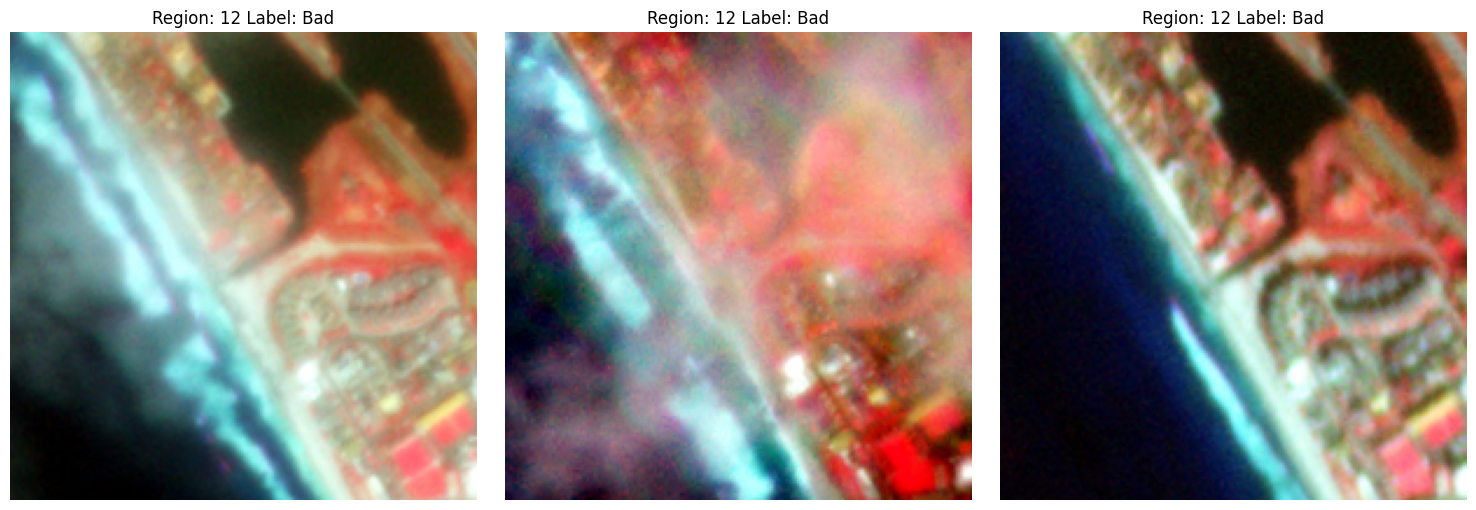

In [55]:
region, images = next(val_bad_iter)

assert len(images), region

cols = min(len(images), 3)
rows = max(1, min(math.ceil(len(images) // 2), 2))
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows))

if len(images) == 1:
    axs = [[axs]]
elif rows == 1:
    axs = [axs]
axs = [ax for axx in axs for ax in axx]
for (source_tif, y_true), ax in zip(images, axs, strict=False):
    ax.set_axis_off()

    with rasterio.open(source_tif) as src:
        data = src.read(out_dtype=np.float32)
        nodata = src.read(1, masked=True).mask
        img = false_color(data, nodata)
        img = Image.fromarray(img)
    label = "Good" if y_true == 0 else "Bad"
    ax.imshow(img)
    ax.set_title(f"Region: {region} Label: {label}")

plt.tight_layout()
plt.show()

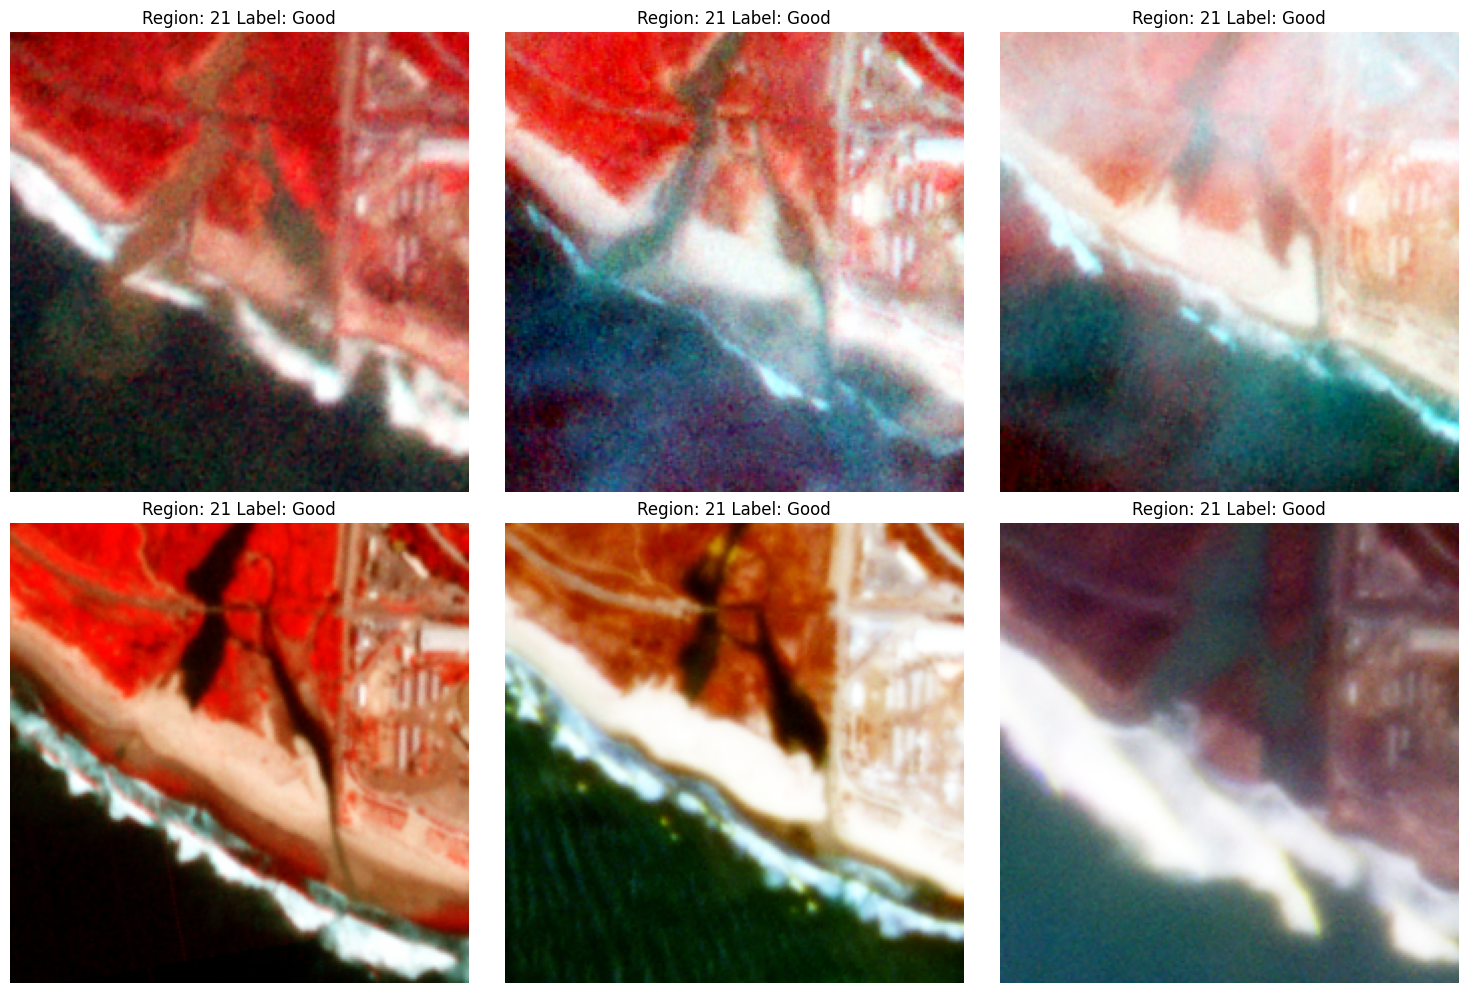

In [58]:
region, images = next(test_good_iter)

assert len(images), region

cols = min(len(images), 3)
rows = max(1, min(math.ceil(len(images) // 2), 2))
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows))

if len(images) == 1:
    axs = [[axs]]
elif rows == 1:
    axs = [axs]
axs = [ax for axx in axs for ax in axx]
for (source_tif, y_true), ax in zip(images, axs, strict=False):
    with rasterio.open(source_tif) as src:
        data = src.read(out_dtype=np.float32)
        nodata = src.read(1, masked=True).mask
        if len(data) == 4:
            img = false_color(data, nodata)
        else:
            img = broad_band(data, nodata)
        img = Image.fromarray(img)
    label = "Good" if y_true == 0 else "Bad"
    ax.axis("off")
    ax.imshow(img)
    ax.set_title(f"Region: {region} Label: {label}")

plt.tight_layout()
plt.show()

In [ ]:
region, images = next(train_iter)

assert len(images), region

cols = min(len(images), 3)
rows = max(1, min(math.ceil(len(images) // 2), 2))
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows))

if len(images) == 1:
    axs = [[axs]]
elif rows == 1:
    axs = [axs]
axs = [ax for axx in axs for ax in axx]
for (source_tif, y_true), ax in zip(images, axs, strict=False):
    with rasterio.open(source_tif) as src:
        data = src.read(out_dtype=np.float32)
        nodata = src.read(1, masked=True).mask
        if len(data) == 4:
            img = false_color(data, nodata)
        else:
            img = broad_band(data, nodata)
        img = Image.fromarray(img)
    label = "Closed" if y_true == 0 else "Open"
    ax.imshow(img)
    ax.set_title(f"Region: {region} Label: {label}")

plt.tight_layout()
plt.show()

In [ ]:
all_labels = _load_labels(module.conf.classes, module.conf.data)
results_df = pd.merge(
    results_df, all_labels[["source_tif", "orig_label"]], on="source_tif", how="left"
)

In [ ]:
# for _, row in tqdm.tqdm(
#     results_df[~results_df.correct].iterrows(), total=(~results_df.correct).sum()
# ):
#     label = "_".join(row.orig_label.split(" "))
#     with rasterio.open(row.source_tif) as src:
#         data = src.read(out_dtype=np.float32)
#         nodata = src.read(1, masked=True).mask
#         if len(data) == 4:
#             img = false_color(data, nodata)
#         else:
#             img = broad_band(data, nodata)
#         img = Image.fromarray(img)

#     save_dir = Path("/Volumes/x10pro/estuary/ca_all/inspect_all_sites/") / label
#     save_dir.mkdir(exist_ok=True, parents=True)
#     img.save(save_dir / f"{Path(row.source_tif).stem}.jpg")

In [ ]:
ca_all_labels = _load_labels(
    module.conf.classes, "/Volumes/x10pro/estuary/ca_all/dove/labeling/labels.csv"
)
ca_results_list = []

ds = EstuaryDataset(
    df=ca_all_labels,
    conf=module.conf,
    train=False,
)
dl = DataLoader(
    ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = ds.transforms(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

    for i in range(len(probs_pos)):
        ca_results_list.append(
            {
                "source_tif": batch["source_tif"][i],
                "y_true": batch["label"][i].detach().cpu().numpy(),
                "y_prob": probs_pos[i].detach().cpu().numpy()[0],
                "y_pred": (probs_pos[i] > 0.5).to(torch.int32).detach().cpu().numpy()[0],
                "region": int(Path(batch["source_tif"][i]).parents[1].name),
                "dataset": "train",
            }
        )

accuracy_score(y_true, np.int32(np.array(y_prob) > 0.5))

In [ ]:
ca_results_df = pd.DataFrame(ca_results_list)
ca_results_df = pd.merge(
    ca_results_df, ca_all_labels[["source_tif", "orig_label"]], on="source_tif", how="left"
)
ca_results_df["correct"] = ca_results_df.y_true == ca_results_df.y_pred
ca_results_df.head()

In [ ]:
ca_results_df = pd.read_csv(
    "/Users/kyledorman/data/results/estuary/train/20251021-151419/timeseries_preds.csv"
)

In [ ]:
ca_results_df.groupby("orig_label").correct.mean()

In [ ]:
ca_results_df.groupby(["region", "orig_label"]).correct.mean()